# Quick Start: Federated Learning Demo

A minimal example to get started with federated learning for predictive maintenance.

Run each cell in order to see federated learning in action!

In [11]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import copy
import matplotlib.pyplot as plt

from src.utils import set_seed
from src.models.tcn import RULPredictor
from src.server.aggregator import FedAvgAggregator  # Direct import bypasses app.py

set_seed(42)
print('✅ Setup complete!')

✅ Setup complete!


In [12]:
# Generate synthetic data for 3 clients
def make_client_data(client_id, n=200):
    np.random.seed(42 + client_id)
    X = np.random.randn(n, 50, 14).astype(np.float32)
    y = np.random.rand(n).astype(np.float32) * 100  # RUL 0-100
    return X, y

clients = {i: make_client_data(i) for i in range(3)}
print(f'✅ Created {len(clients)} clients with {clients[0][0].shape[0]} samples each')

✅ Created 3 clients with 200 samples each


In [13]:
# Initialize model and aggregator
global_model = RULPredictor(num_channels=14, hidden=32, num_layers=3)
aggregator = FedAvgAggregator()

print(f'✅ Model: {sum(p.numel() for p in global_model.parameters()):,} parameters')

✅ Model: 18,849 parameters


In [15]:
# Federated Training Loop
NUM_ROUNDS = 10
LOCAL_EPOCHS = 2
history = []

for round_id in range(1, NUM_ROUNDS + 1):
    # Reset aggregator for new round
    aggregator.reset(round_id)
    
    # Each client trains locally
    for cid, (X, y) in clients.items():
        local_model = copy.deepcopy(global_model)
        opt = torch.optim.Adam(local_model.parameters(), lr=0.001)
        X_t = torch.tensor(X)  # Model expects (N, W, C), transposes internally
        y_t = torch.tensor(y)
        
        # Local training
        local_model.train()
        for _ in range(LOCAL_EPOCHS):
            opt.zero_grad()
            loss = torch.nn.MSELoss()(local_model(X_t).squeeze(), y_t)
            loss.backward()
            opt.step()
        
        # Compute delta (local - global) and submit to aggregator
        delta = {k: local_model.state_dict()[k] - global_model.state_dict()[k] 
                 for k in global_model.state_dict()}
        aggregator.add_update(client_id=str(cid), delta=delta, num_samples=len(X))
    
    # Aggregate and apply updates
    aggregator.aggregate_and_apply(global_model)
    
    # Evaluate
    global_model.eval()
    with torch.no_grad():
        X_all = np.concatenate([c[0] for c in clients.values()])
        y_all = np.concatenate([c[1] for c in clients.values()])
        pred = global_model(torch.tensor(X_all)).squeeze().numpy()  # No permute - model handles it
        mae = np.mean(np.abs(pred - y_all))
    
    history.append(mae)
    print(f'Round {round_id:2d}: MAE = {mae:.2f}')

print('\n✅ Training complete!')

Round  1: MAE = 50.72
Round  2: MAE = 50.15
Round  3: MAE = 49.71
Round  4: MAE = 49.35
Round  5: MAE = 49.03
Round  6: MAE = 48.73
Round  7: MAE = 48.44
Round  8: MAE = 48.16
Round  9: MAE = 47.89
Round 10: MAE = 47.63

✅ Training complete!


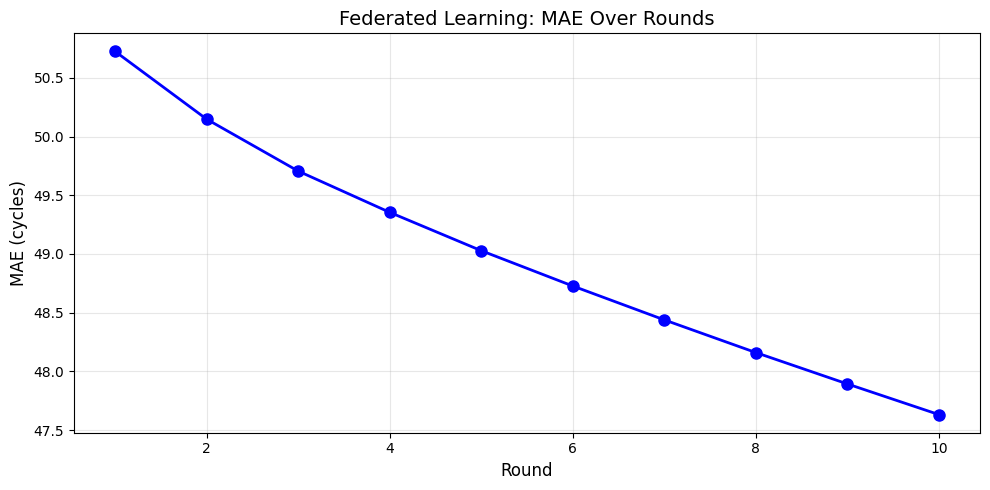

📊 Final MAE: 47.63 cycles
📊 Best MAE:  47.63 cycles (round 10)


In [16]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_ROUNDS + 1), history, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Round', fontsize=12)
plt.ylabel('MAE (cycles)', fontsize=12)
plt.title('Federated Learning: MAE Over Rounds', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'📊 Final MAE: {history[-1]:.2f} cycles')
print(f'📊 Best MAE:  {min(history):.2f} cycles (round {history.index(min(history)) + 1})')

## 🎉 That's it!

You've successfully run a federated learning experiment!

### Next Steps:
- Run `01_federated_evaluation.ipynb` for comprehensive evaluation
- Run `02_privacy_analysis.ipynb` for privacy metrics
- Check `experiments/` folder for saved results